In [1]:
from globus_automate_client import create_flows_client
import time
import json
import sys
import os

from datetime import datetime
from dateutil import parser
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [2]:
DATA_COMPUTE = {'xpcs': {'data': 2.415, 'fx': 122},
                'ssx': {'data': 3.453, 'fx': 317},
               'slac': {'data': 21.943, 'fx': 166},
               'ptycho': {'data': 0.048, 'fx': 2155},
               'hedm': {'data': 11.517, 'fx': 396}}

# Flow step counts

In [3]:
df = pd.read_csv('flow_data.csv')

In [4]:
dfcount = df.groupby(['experiment']).sum().reset_index()

In [5]:
dfcount

,experiment,Unnamed: 0,funcx_count,transfer_count,search_count,total_runs
0,hedm,5238656,785,380,171,188
1,ptycho,294557268,16415,39183,0,16296
2,slac,29847675,754,1497,0,744
3,ssx,701090759,65220,24322,2478,21346
4,xpcs,662740145,99083,53049,28424,19624


# Data and compute

In [6]:
df = pd.read_csv('flow_data.csv')

Truncate

In [7]:
df = df[(df['created'] > '2019-12-31') & (df['created'] < '2022-01-01')]
df = df[(df['experiment'] == 'ssx') | (df['experiment'] == 'xpcs') | (df['experiment'] == 'hedm') | (df['experiment'] == 'slac') | (df['experiment'] == 'ptycho')]

## 1. Flows over time

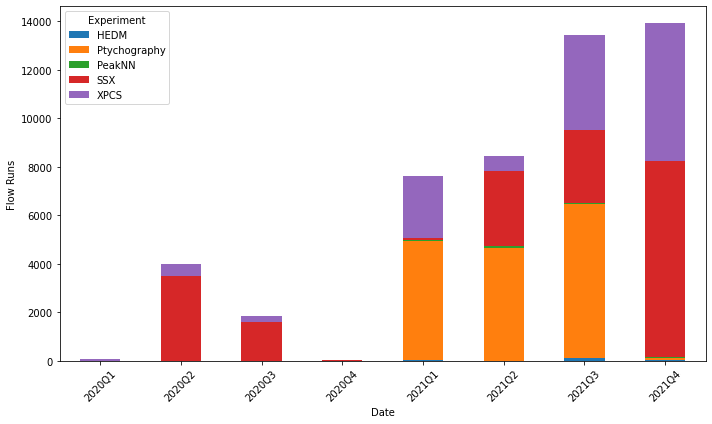

In [8]:
labels=['HEDM', 'Ptychography', 'PeakNN', 'SSX', 'XPCS']

df['count'] = 1
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()

dfq = dfd.pivot(index='quarter_col', columns='experiment', values='count')
dfq.plot.bar(stacked=True, figsize=(10, 6), ylabel='Flow Runs', xlabel='Date')
plt.legend(title='Experiment', loc='upper left', labels=labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('agg_runs.png')

## 2. Data GB transferred

In [9]:
def add_data(row):
    return DATA_COMPUTE[row['experiment']]['data']

def add_compute(row):
    return DATA_COMPUTE[row['experiment']]['fx']
    
df['data'] = df.apply(lambda row: add_data(row), axis=1)
df['compute'] = df.apply(lambda row: add_compute(row), axis=1)

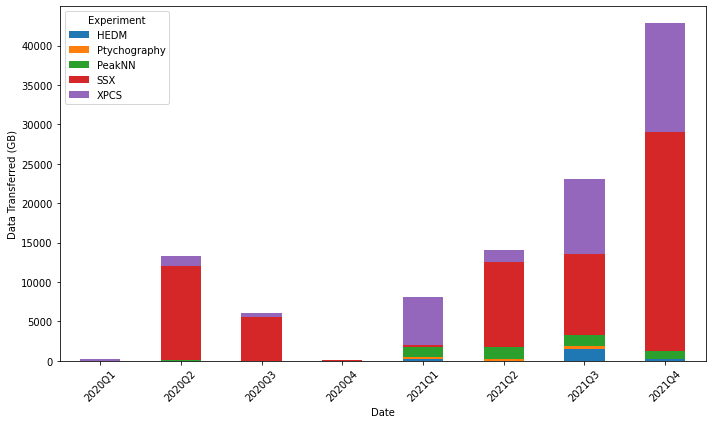

In [10]:
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()
# print(dfd)
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='data')
dfq.plot.bar(stacked=True, figsize=(10, 6), ylabel='Data Transferred (GB)', xlabel='Date')
plt.legend(title='Experiment', loc='upper left', labels=labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('agg_data.png')

## 3. Compute node seconds

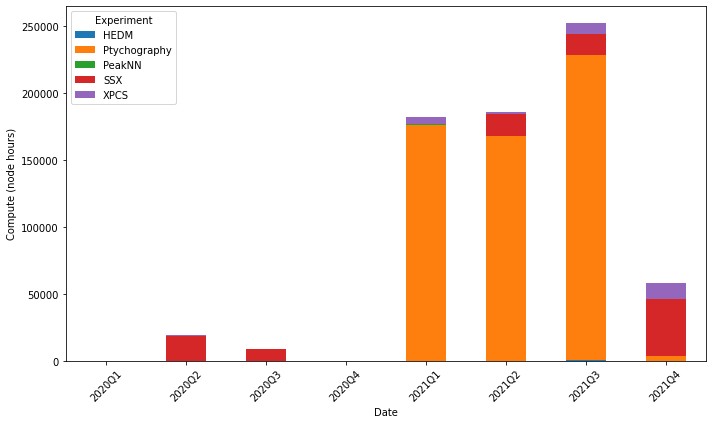

In [11]:
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()
dfd['compute'] = dfd['compute'] / 60
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='compute')
dfq.plot.bar(stacked=True, figsize=(10, 6), ylabel='Compute (node hours)', xlabel='Date')
plt.legend(title='Experiment', loc='upper left', labels=labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('agg_compute.png')

### All three

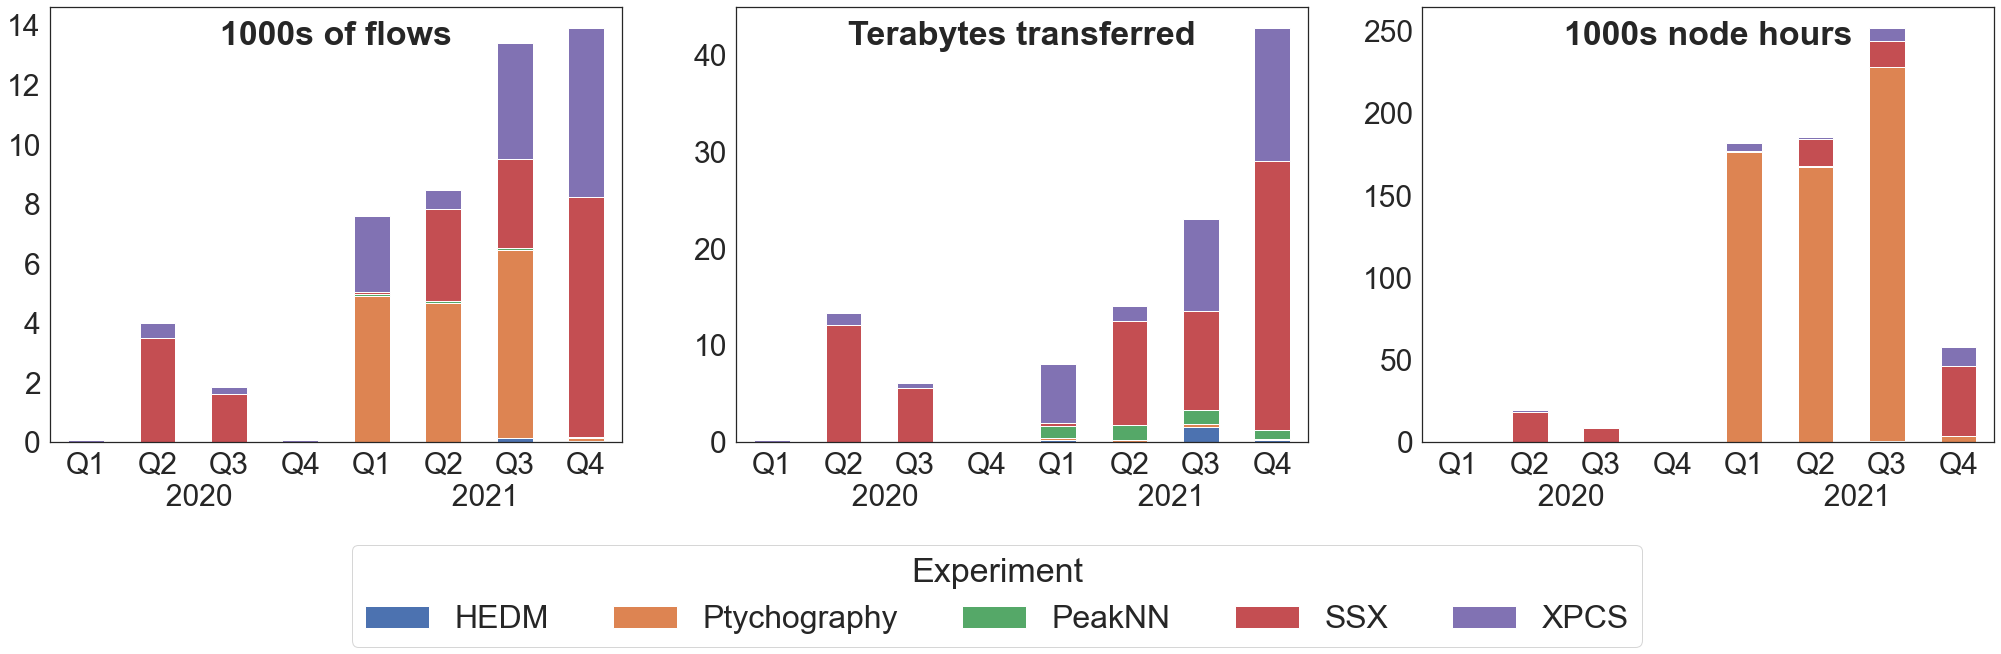

In [125]:
sns.set(font_scale=2.4, style='white')
fig, axs = plt.subplots(ncols=3, sharey=False, sharex=False, figsize=(30,8), )

new_labels = ['Q1', 'Q2\n          2020', 'Q3', 'Q4', 'Q1', 'Q2\n          2021', 'Q3', 'Q4']
tick_size = 30

labels=['HEDM', 'Ptychography', 'PeakNN', 'SSX', 'XPCS']

df['count'] = 1
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()

dfd['count'] = dfd['count'] / 1000
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='count')
ax=dfq.plot.bar(stacked=True, xlabel='Date', ax=axs[0], fontsize=tick_size)
ax.set_title('1000s of flows',  y=0.90, fontsize=34, weight='bold')
ax.set_xlabel(None)
ax.set_xticklabels(new_labels, rotation=0, fontsize=tick_size)
#ax.set_yticklabels([int(y.get_text())/1000 for y in ylabels[1]])
ax.legend().remove()

dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()
dfd['data'] = dfd['data'] /1000
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='data')
ax1 = dfq.plot.bar(stacked=True, xlabel='Date', ax=axs[1], fontsize=tick_size)
ax1.set_title('Terabytes transferred', y=0.90, fontsize=34, weight='bold')
ax1.set_xlabel(None)
#ax1.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax1.set_xticklabels(new_labels, rotation=0, fontsize=tick_size)
ticks = plt.xticks()
ax1.legend().remove()

dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()
dfd['compute'] = dfd['compute'] /60000
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='compute')
ax2 = dfq.plot.bar(stacked=True, xlabel='Date', ax=axs[2], fontsize=tick_size)
ax2.set_title("1000s node hours", y=0.90, fontsize=34, weight='bold')
ax2.set_xlabel(None)

# ax.set_yscale("log") # Bringing this back set sharey=True

# plt.legend(title='Experiment', loc = 2, bbox_to_anchor = (-1.85,1.4), labels=labels, ncol=5)
legend = plt.legend(title='Experiment', loc = 2, bbox_to_anchor = (-1.9,-0.2), labels=labels, ncol=5, fontsize=32)
plt.setp(legend.get_title(),fontsize=34)
plt.subplots_adjust(left=0)
ticks = plt.xticks()
new_labels = ['Q1', 'Q2\n          2020', 'Q3', 'Q4', 'Q1', 'Q2\n          2021', 'Q3', 'Q4',]
plt.xticks(ticks[0], new_labels, rotation=0, fontsize=tick_size)

plt.savefig('agg_all.png', bbox_inches="tight")

# Overhead

In [126]:
sns.set(font_scale=2.4, style='white')
def plot_overhead(exps, labels=['XPCS']):
    fig, gnt = plt.subplots(figsize=(12, 8))
    gnt.grid(True)

    colors = sns.color_palette('Set2')

    def get_col(tasktype):
        if tasktype == 'transfer':
            return colors[2]
        if tasktype == 'funcx':
            return colors[1]
        if tasktype == 'search':
            return colors[3]

    i = 0
    for exp in exps:
        total = 0
        for task in exp:
            gnt.broken_barh([(total, task['real_time'])], ((i+1)*10, 6), facecolor=get_col(task['type']), edgecolor='black')
            total += task['runtime']
        gnt.broken_barh([(total, 0)], ((i+ 1)*10, 6), facecolor=get_col(4), edgecolor='red')
        i += 1
        
    plt.xlabel("Time (s)")
    plt.ylabel("")
    
    ticks = []
    i = 1
    for ll in labels:
        ticks.append(i*10 + 3)
        i+=1
    plt.yticks(ticks, labels)
    plt.tight_layout()
    plt.savefig('overhead_breakdown.png')

In [127]:
with open('overhead_bars.json', 'r') as fp:
    overhead_dict = json.load(fp)
print(overhe)

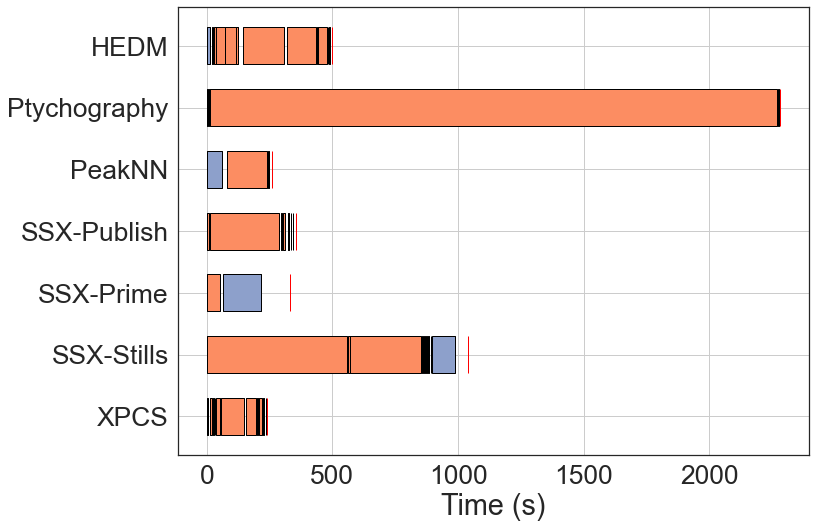

In [129]:
plot_overhead([overhead_dict['xpcs'], overhead_dict['ssx_stills'], 
               overhead_dict['ssx_prime'], overhead_dict['ssx_publish'], overhead_dict['peaknn'], overhead_dict['ptycho'],
               overhead_dict['hedm']], 
              ['XPCS', 'SSX-Stills', 'SSX-Prime', 'SSX-Publish', 'PeakNN', 'Ptychography', 'HEDM'])

# Runtime histograms

In [134]:
df = pd.read_csv('xpcs_runs_2.csv')

df['Date'] = pd.to_datetime(df['start'], unit='s')

df['date_col'] = df['Date'].dt.to_period('M') 
df['quarter_col'] = df['Date'].dt.to_period('Q')
df['day_col'] = df['Date'].dt.to_period('D')

df['experiment'] = 'xpcs'

In [135]:
# for coln in cols:
#     df2 = df[coln]
#     print(coln)
#     sns.set(font_scale=1.4, style='white')
#     plt.figure(figsize=(6,6))
#     ax = sns.histplot(data=df2)

#     ax.set_ylabel("Count")
#     ax.set_xlabel("Time (s)")
#     ax.set_yscale("log")
#     ax.set_xscale("log")
#     ax.set_xlim([0.01,1000])
#     plt.tight_layout()
#     plt.savefig(f'xpcs_{coln.lower()}.png')
#     plt.show()

TransferFromClutchToTheta_runtime
PrePublishGatherMetadata_runtime
PrePublishTransfer_runtime
PrePublishIngest_runtime
AcquireNodes_runtime
XpcsBoostCorr_runtime
MakeCorrPlots_runtime
GatherXpcsMetadata_runtime
PublishGatherMetadata_runtime
PublishTransfer_runtime
PublishIngest_runtime


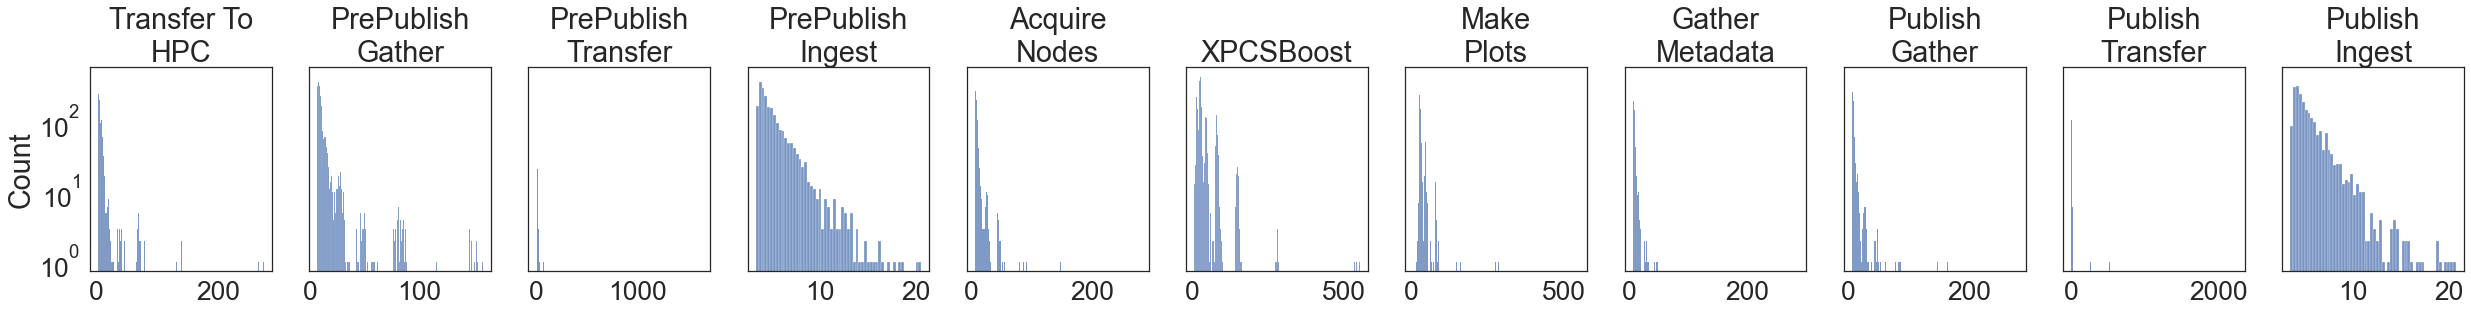

In [136]:
hist_labels = {'TransferFromClutchToTheta': 'Transfer To\nHPC',
         'PrePublishGatherMetadata': 'PrePublish\nGather',
         'PrePublishTransfer': 'PrePublish\nTransfer',
         'PrePublishIngest': 'PrePublish\nIngest',
         'AcquireNodes': 'Acquire\nNodes',
         'XpcsBoostCorr': 'XPCSBoost',
         'MakeCorrPlots': 'Make\nPlots',
         'GatherXpcsMetadata': 'Gather\nMetadata',
         'PublishGatherMetadata': 'Publish\nGather',
         'PublishTransfer': 'Publish\nTransfer',
         'PublishIngest': 'Publish\nIngest'}

cols = df.columns[df.columns.str.contains(pat = '_runtime') & ~df.columns.str.contains(pat = 'flow_runtime')] 

df2 = df[cols[0]]

sns.set(font_scale=2.4, style='white')
fig, axs = plt.subplots(ncols=11, sharey=True, sharex=False, figsize=(35,5), )
i = 0
for coln in cols:
    df2 = df[coln]
    print(coln)
    ax = sns.histplot(data=df2, ax=axs[i])
    ax.set_title(hist_labels[coln.replace("_runtime","")])
    ax.set_xlabel(None)
    i+=1
    ax.set_yscale("log")
    plt.tight_layout()
plt.savefig(f'xpcs_runtime_hists.png')

plt.show()

# Overhead historgrams

In [137]:
tasks = pd.read_csv('tasks_overheads.csv')
df = pd.read_csv('xpcs_runs_2.csv')
df['PublishGatherMetadata_action_time'] = np.nan
df['AcquireNodes_action_time'] = np.nan
df['XpcsBoostCorr_action_time'] = np.nan
df['MakeCorrPlots_action_time'] = np.nan
df['GatherXpcsMetadata_action_time'] = np.nan

In [138]:
fx_map = {'PrePublishGatherMetadata': '8ce4e858-8da2-4bb7-a188-323ddff77e80',
 'AcquireNodes': 'f82ce53f-467f-4c49-9ac3-d278341ab4cf',
 'XpcsBoostCorr': '62b02c2d-ea5a-4ba4-aca7-c9e175a8b47e',
 'MakeCorrPlots': 'd67069b0-faca-42ac-a34d-777fed84d3a6',
 'GatherXpcsMetadata': '4db5ddba-be38-417c-b556-2e306185a994',
 'PublishGatherMetadata': '1347dc22-51ff-41bf-9cf5-8b20eb8e6f97'}

map_fx = {}
fx_list = []
for k,v in fx_map.items():
    fx_list.append(v)
    map_fx[v] = k

In [139]:
for index, row in df.iterrows():
    for y in json.loads(row['funcx_task_ids'].replace("\'", "\"")):
        try:
            fxtask = tasks[tasks['aid'] == y]
            fxt = fxtask['total_funcx_time'].values[0]
            df.at[index,map_fx[fxtask['function_id'].values[0]]+"_action_time"] = fxt
        except Exception as e:
            pass

Now we have action_time and runtime on each action in the df dataframe. compute overhead, then plot.

In [140]:
filter_col = [col for col in df if col.endswith('_runtime')]

In [141]:
for c in filter_col:
    if c == "flow_runtime":
        continue
    cn = c.split("_")[0]
    df[cn+"_overhead"] = df[cn+"_runtime"] - df[cn+"_action_time"]

In [142]:
df['PrePublishIngest_overhead']

0       4.069
1       8.590
2       4.393
3       3.765
4       3.209
        ...  
2192    7.048
2193    5.231
2194    3.808
2195    3.817
2196    4.085
Name: PrePublishIngest_overhead, Length: 2197, dtype: float64

In [143]:
# filter_col = [col for col in df if col.endswith('_overhead')]

# for coln in filter_col:
#     df2 = df[coln]
    
#     print(coln)
#     sns.set(font_scale=1.4, style='white')
#     plt.figure(figsize=(10,6))
#     ax = sns.histplot(data=df2)

#     ax.set_ylabel("Count")
#     ax.set_xlabel("Time (s)")
#     ax.set_yscale("log")
#     plt.tight_layout()
#     plt.savefig(f'xpcs_{coln.lower()}.png')

#     plt.show()

TransferFromClutchToTheta_overhead
PrePublishGatherMetadata_overhead
PrePublishTransfer_overhead
PrePublishIngest_overhead
AcquireNodes_overhead
XpcsBoostCorr_overhead
MakeCorrPlots_overhead
GatherXpcsMetadata_overhead
PublishGatherMetadata_overhead
PublishTransfer_overhead
PublishIngest_overhead


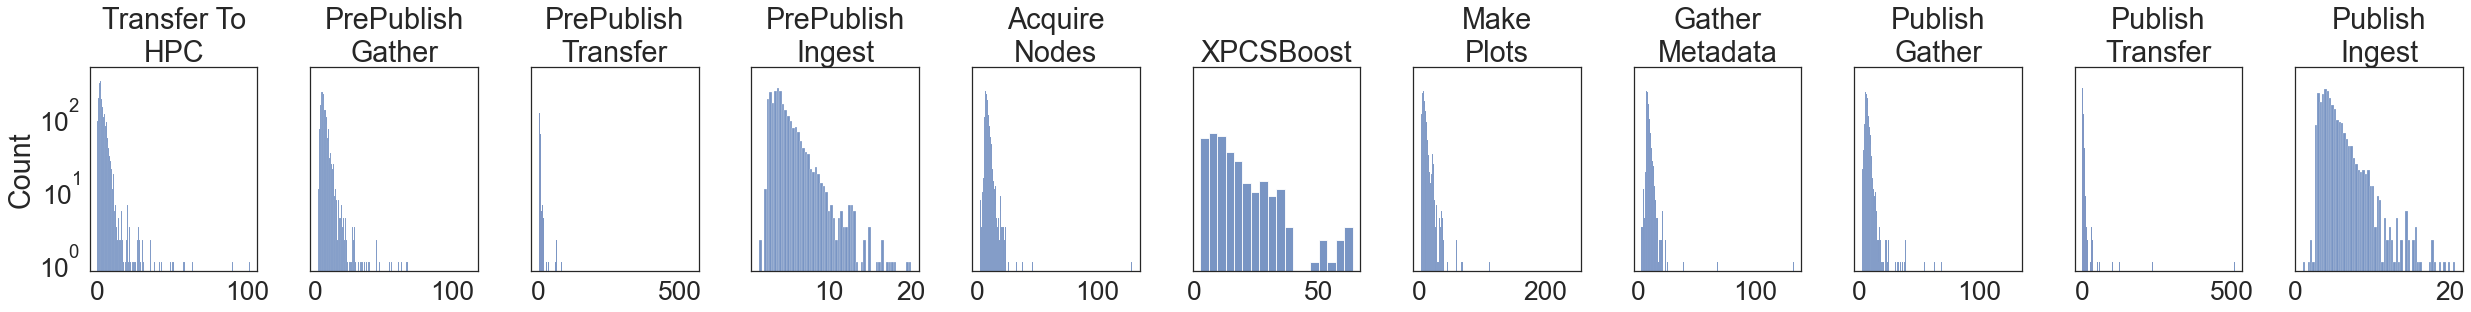

In [144]:
filter_col = [col for col in df if col.endswith('_overhead')]

sns.set(font_scale=2.4, style='white')
fig, axs = plt.subplots(ncols=11, sharey=True, sharex=False, figsize=(35,5), )
i = 0
for coln in filter_col:
    df2 = df[coln]
    print(coln)
    ax = sns.histplot(data=df2, ax=axs[i])
    ax.set_title(hist_labels[coln.replace("_overhead", "")])
    ax.set_xlabel(None)
    i+=1
    ax.set_yscale("log")
    plt.tight_layout()
plt.savefig(f'xpcs_overhead_hists.png')

plt.show()

# Concurrent flows

In [145]:
df = pd.read_csv('xpcs_runs_2.csv')

In [146]:
df2 = df
active_events= []
for i in df2.index:
    active_events.append(len(df2[(df2["start"]<=df2.loc[i,"start"]) & 
                                (df2["end"]> df2.loc[i,"start"])]))
df2['activecalls'] = pd.Series(active_events)

<AxesSubplot:xlabel='start', ylabel='activecalls'>

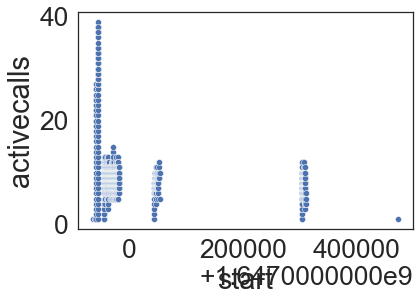

In [147]:
sns.scatterplot(data=df2, x='start', y='activecalls')

In [148]:
df2 = df

df2['Date'] = pd.to_datetime(df2['start'], unit='s')
df2['date_hour'] = df2['Date'].dt.to_period('h') 
df2 = df2[(df2['Date'] > '2022-03-11') & (df2['Date'] < '2022-03-12')]

In [149]:
active_events = []
for i in df2.index:
    active_events.append(len(df2[(df2["start"]<=df2.loc[i,"start"]) & 
                                (df2["end"]> df2.loc[i,"start"])]))
df2['activecalls'] = pd.Series(active_events)

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<AxesSubplot:xlabel='Date', ylabel='activecalls'>

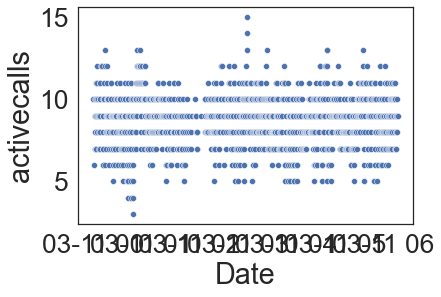

In [150]:
sns.scatterplot(data=df2, x='Date', y='activecalls')

In [151]:
dfx = df

In [152]:
dfx['start'] = pd.to_datetime(dfx['start'], unit='s')
dfx['end'] = pd.to_datetime(dfx['end'], unit='s')

In [153]:
starts = (x - pd.Timedelta(seconds=x.second) for x in dfx['start'])
ends = (x - pd.Timedelta(seconds=x.second) for x in dfx['end'])
ranges = (pd.date_range(x,y,freq='1D') for x,y in zip(starts,ends))
ranges = pd.Series(chain.from_iterable(ranges))
output = ranges.value_counts(sort=False).sort_index()

In [154]:
df2 = df[(df['Date'] > '2022-03-10') & (df['Date'] < '2022-03-12')]
min_time = df2['start'].min()
max_time = df2['end'].max()
ts_index = pd.date_range(min_time, max_time, freq = 's')

In [155]:
concurrency_array = dfx.apply(lambda e: ((ts_index >= e['start']) & (ts_index <= e['end'])).astype(int), axis='columns').sum()
concurrency = pd.Series(concurrency_array, index = ts_index)

In [156]:
concurrency.describe()

count    45513.000000
mean         5.558873
std          5.286086
min          0.000000
25%          0.000000
50%          7.000000
75%          9.000000
max         39.000000
dtype: float64

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


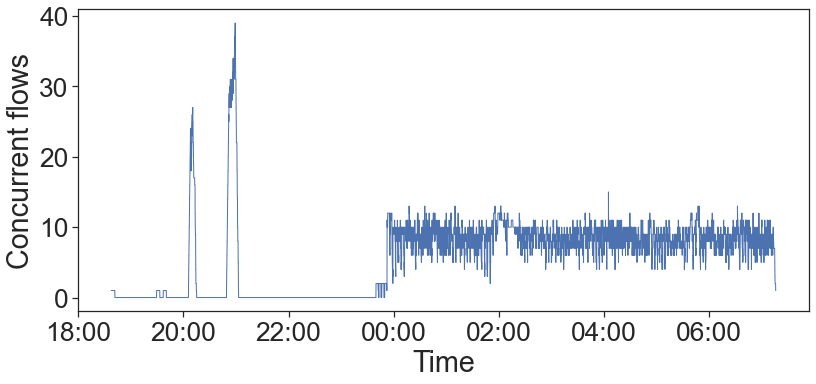

In [184]:
sns.set(font_scale=2.4, style='white')
plt.figure(figsize=(12,6))
p = sns.lineplot(data=concurrency, linewidth=1)

p.set_ylabel("Concurrent flows")
p.set_xlabel("Time")

# p.set_xticklabels([1,2,3,4,5,6,7,8,9])
p.set_xticklabels(['18:00','20:00','22:00','00:00','02:00','04:00','06:00'], rotation=0, ha="center")
p.tick_params(left=True, bottom=True)
plt.tight_layout()
plt.savefig('concurrent_flows.png', dpi='figure')

In [158]:
# Can resample to whatever binning period
concurrency2 = concurrency.resample('1H').max()

<AxesSubplot:>

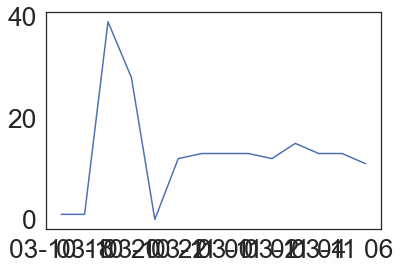

In [159]:
sns.lineplot(data=concurrency2)

# Runtime distributions

In [160]:
# Start with XPCS data as its easiest

df = pd.read_csv('xpcs_runs_2.csv')
df['experiment'] = 'XPCS'
df_xpcs = df[['flow_runtime', 'experiment']]


# SLAC
df_slac = pd.read_csv('slac_runs.csv')
df_slac['experiment'] = 'PeakNN'

# HEDM
df_hedm = pd.read_csv('hedm_runs.csv')
df_hedm['experiment'] = 'HEDM'

# SSX
df_prime = pd.read_csv('prime_runs.csv')
df_prime['experiment'] = 'SSX-PRIME'
df_transfer = pd.read_csv('ssx_publish.csv')
df_transfer['experiment'] = 'SSX-Publish'
df_stills = pd.read_csv('stills_runs.csv')
df_stills['experiment'] = 'SSX-Stills'


# Ptycho
df_ptycho = pd.read_csv('ptycho_runs.csv')
df_ptycho['experiment'] = 'Ptychography'

df_all = df[['flow_runtime', 'experiment']]
df_all = df_all.append(df_stills[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_prime[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_transfer[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_slac[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_ptycho[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_hedm[['flow_runtime', 'experiment']], ignore_index=True)

In [161]:
df_ptycho['flow_runtime'].describe()

count      74.000000
mean     2177.131975
std      1420.733539
min        31.397206
25%       553.929436
50%      2879.614328
75%      3488.519938
max      3527.506117
Name: flow_runtime, dtype: float64

/Users/ian/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ian/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

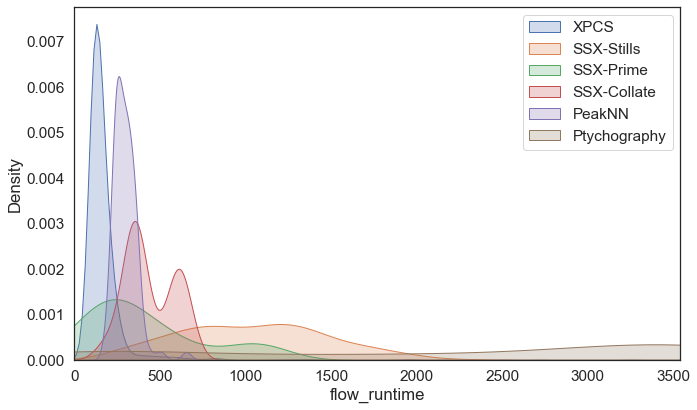

In [162]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(10,6))

ax = sns.distplot(df_xpcs['flow_runtime'], hist=False, label='XPCS', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_stills['flow_runtime'], hist=False, label='SSX-Stills', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_prime['flow_runtime'], hist=False, label='SSX-Prime', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_transfer['flow_runtime'], hist=False, label='SSX-Collate', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_slac['flow_runtime'], hist=False, label='PeakNN', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_ptycho['flow_runtime'], hist=False, label='Ptychography', kde_kws={"shade": True}).set(xlim=(0))

plt.legend()

plt.tight_layout()
plt.savefig('runtime_distribution.png')

<Figure size 720x432 with 0 Axes>

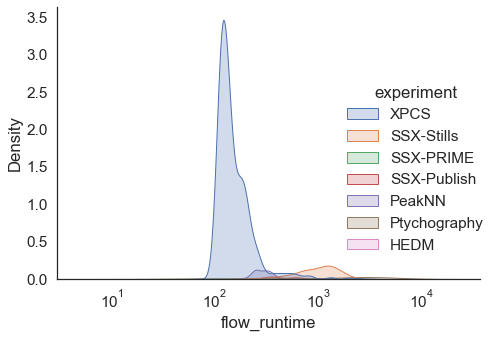

In [163]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(10,6))

ax = sns.displot(df_all, x="flow_runtime",kind='kde', fill=True, hue='experiment', log_scale=True)

plt.tight_layout()
plt.savefig('runtime_displot.png')

In [164]:
# ax = sns.kdeplot(data=df_all, x='flow_runtime', hue='experiment')

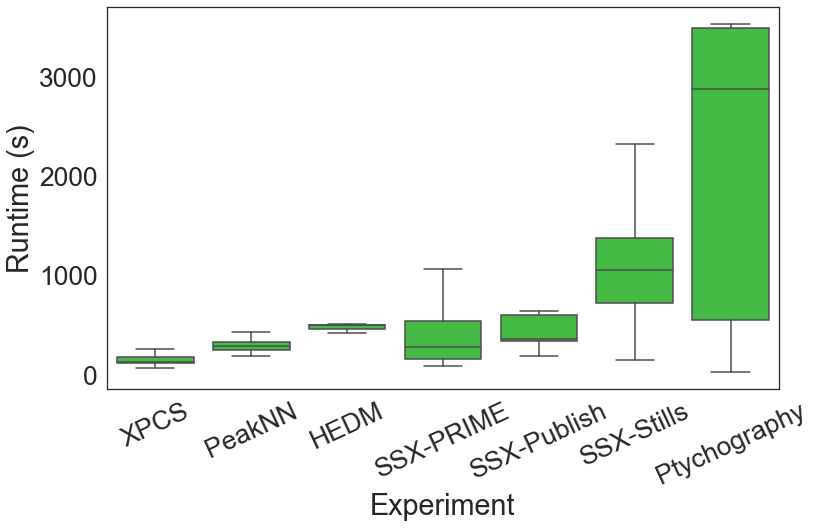

In [165]:
sns.set(font_scale=2.4, style='white')
plt.figure(figsize=(12,8))

ax = sns.boxplot(x="experiment", y="flow_runtime", color="limegreen", data=df_all, showfliers=False, 
                 order=['XPCS', 'PeakNN', 'HEDM', 'SSX-PRIME', 'SSX-Publish', 'SSX-Stills', 'Ptychography'])
ax.set_ylabel("Runtime (s)")
ax.set_xlabel("Experiment")

plt.xticks(rotation=25)#, ha="right")
plt.tight_layout()
plt.savefig('runtime_boxplot.png')